In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend
import pandas as pd

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [66]:
pl.rc('font', size = 16)
pl.rc('legend', fontsize = 16)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
TdayTotalStars = sim['SnapNumber_128/PartType4/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
# and now to locate the firts pericentre, and the distance to the centre.
def getperi(gal, center):
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap = rphys[pre], thesnap[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn

In [8]:
# let's try this
gal, center = 4470, 4469
physD, Snap, mmr, firstsnap, Nturn = getperi(gal, center)

firstsnap, Snap, Nturn

(97, 101, 0.9278289098535862)

In [9]:
uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
uniqueIDC = int(127*1e6+center)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
x, y, z = [], [], []
for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
        
    galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
    vec =  galPos - cenPos
    
    x.append(vec[0])
    y.append(vec[1])
    z.append(vec[2])
    
    if snap==Snap:
        x0, y0, z0 = vec[0], vec[1], vec[2]
        
x, y, z = np.array(x), np.array(y), np.array(z)

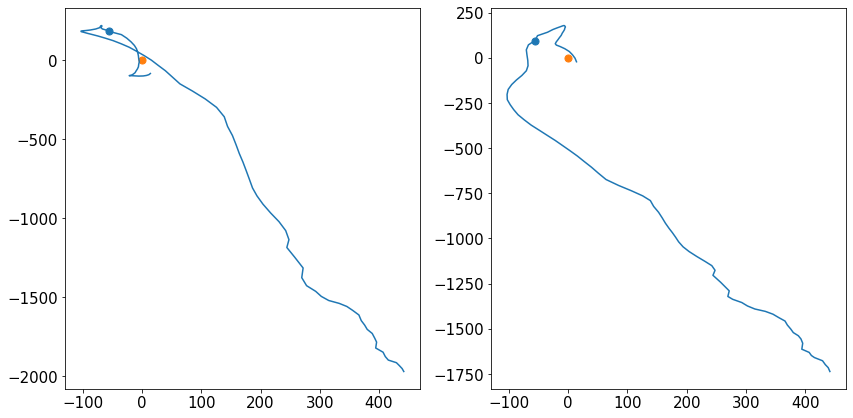

In [10]:
pl.figure(figsize=(14, 7))

pl.subplot(1, 2, 1)

pl.plot(x, y)
pl.scatter(x0, y0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)


pl.subplot(1, 2, 2)

pl.plot(x, z)
pl.scatter(x0, z0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)

In [11]:
# until this is equal to the last, lets see.

def getAllLastP(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, MassList, AbundList = [], [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]

                GMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                MassList.extend(list(GMass))
                AbundList.extend(list(GAbund))

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    MassList = np.array(MassList)
    AbundList = np.array(AbundList)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    MassList = MassList[Idunique]
    AbundList = AbundList[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    MassList_ = MassList[iidex_]
    AbundList_ = AbundList[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Massorder = np.zeros(IndexT_.size)
    Abundorder = np.zeros((IndexT_.size, 12))
    
    snaporder[is1] = snaplist_[is2]
    Massorder[is1] = MassList_[is2]
    Abundorder[is1] = AbundList_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Massorder, Abundorder

In [12]:
# lets see if do not crash, at least, but how to know if thsi is working
snaporder, Massorder, Abundorder = getAllLastP(4471, 4469, 92)

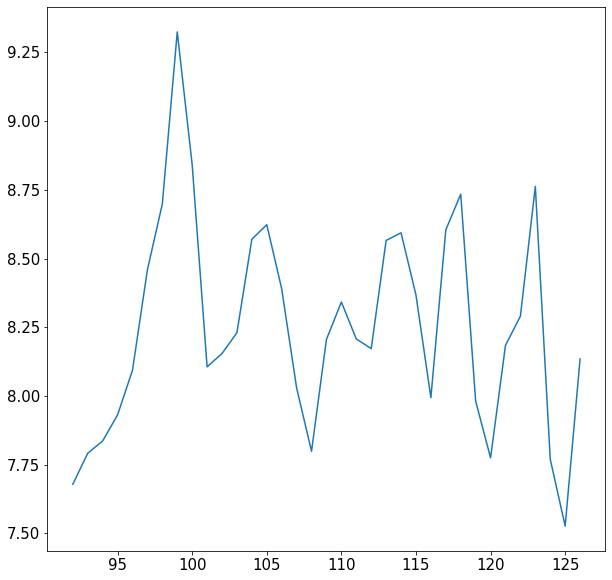

In [13]:
# lets see if at least teh amount of material increases with time
snapu = np.unique(snaporder)

snapMass = []
for s in snapu:
    i = np.where(snaporder==s)
    tmass = Massorder[i]
    snapMass.append(np.log10(np.sum(tmass)*1e10))
    
snapMass = np.array(snapMass)

pl.figure(figsize=(10,10))

pl.plot(snapu, snapMass)

In [14]:
# ok, i think i got it, lets see
gal, cen = 4470, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder = getAllLastP(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

MassPre = np.sum(Massorder[ipre])
MassPost = np.sum(Massorder[ipost])

MassPost/MassPre, np.log10(MassPre*1e10), np.log10(MassPost*1e10), Snap, mmr, physD, Nturn

(2.044036123376136,
 8.934945239120028,
 9.245433805751146,
 101,
 88.55082,
 215.69713,
 0.9278289098535862)

In [15]:
listOfGal = np.array([4338, 4339, 4341, 4343, 4470, 4471, 4473, 4474])
listOfCen = np.array([4337, 4337, 4337, 4337, 4469, 4469, 4469, 4469])

In [16]:
# i think i need to measure the number of laps, but later.

ratio = []
MassRatio = []
minDist = []
periDist = []
NLaps = []
difFeH = []
difOFe = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, Massorder, Abundorder = getAllLastP(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)

    AbundPre = Abundorder[ipre]
    AbundPost = Abundorder[ipost]
    
    FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
    FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

    iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
    iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
    FeHPre = FeHPre[iFpre]
    FeHPost = FeHPost[iFpost]
    
    OFePre = np.log10((AbundPre[:,3]/OMass)/(AbundPre[:,4]/FeMass)) - NoNfe_sun
    OFePost = np.log10((AbundPost[:,3]/OMass)/(AbundPost[:,4]/FeMass)) - NoNfe_sun
    
    iOpre = np.where((np.isnan(OFePre)==False) & (np.isinf(OFePre)==False))
    iOpost = np.where((np.isnan(OFePost)==False) & (np.isinf(OFePost)==False))
    
    OFePre = OFePre[iOpre]
    OFePost = OFePost[iOpost]
    
    difFeH_pp = np.median(FeHPost) - np.median(FeHPre)
    difOFe_pp = np.median(OFePost) - np.median(OFePre)
    
    difFeH.append(difFeH_pp)
    difOFe.append(difOFe_pp)
    
    MassPre = np.sum(Massorder[ipre])
    MassPost = np.sum(Massorder[ipost])
    
    ratio.append(MassPost/MassPre)
    
    
    tempOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][gal]

    posPart = sim['SnapNumber_128/PartType4/Coordinates'][tempOff[0]:tempOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    rr = np.sqrt(xx**2+yy**2+zz**2)

    ik = np.where(rr<rop)[0]
    GalMass = sim['SnapNumber_128/PartType4/Masses'][tempOff[0]:tempOff[1]]
    GalMass = GalMass[ik]
    
    tempOffC = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][cen].astype('int')
    ropC = sim['SnapNumber_128/SubGroups/OpticalRadius'][cen]

    posPartC = sim['SnapNumber_128/PartType4/Coordinates'][tempOffC[0]:tempOffC[1]]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

    xxC, yyC, zzC = posPartC[:,0] - posCen[0], posPartC[:,1] - posCen[1], posPartC[:,2] - posCen[2]

    rrC = np.sqrt(xxC**2+yyC**2+zzC**2)

    ikC = np.where(rrC<ropC)[0]
    CenMass = sim['SnapNumber_128/PartType4/Masses'][tempOffC[0]:tempOffC[1]]
    CenMass = CenMass[ikC]
    
    MassRatio.append(np.sum(GalMass)/np.sum(CenMass))
    
    minDist.append(mmr)
    periDist.append(physD)
    NLaps.append(Nturn)
    
    c += 1
    bar.update(c)
    

ratio = np.array(ratio)
MassRatio = np.array(MassRatio)
minDist = np.array(minDist)
periDist = np.array(periDist)
NLaps = np.array(NLaps)
difFeH = np.array(difFeH)
difOFe = np.array(difOFe)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
100% (8 of 8) |##########################| Elapsed Time: 0:00:12 ETA:  00:00:00

Text(0, 0.5, '$M_{post}/M_{pre}$')

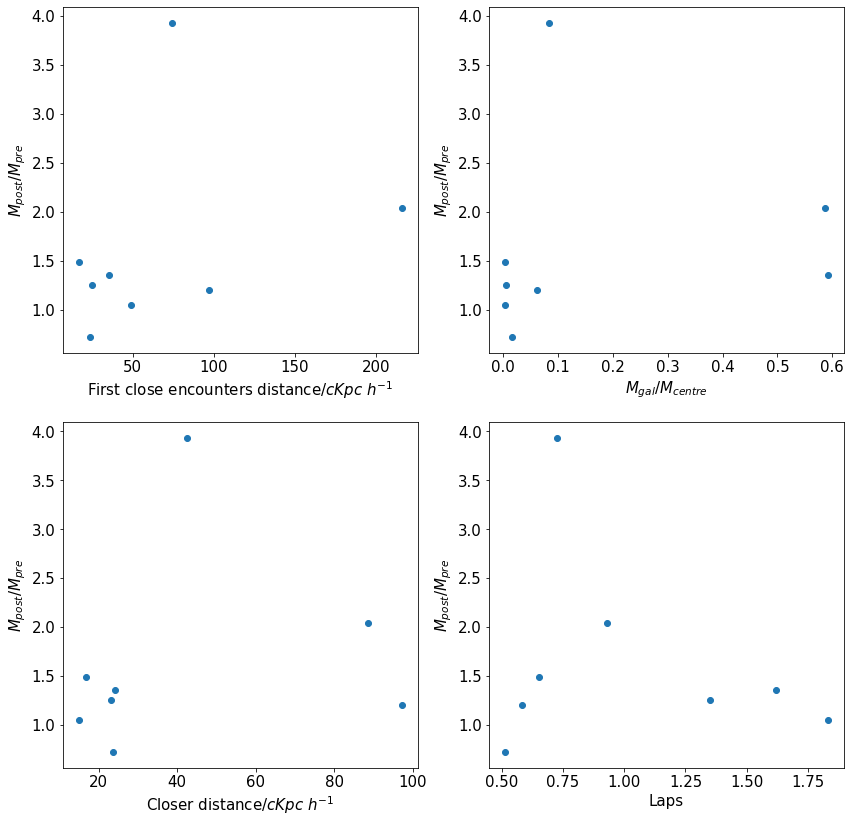

In [17]:
pl.figure(figsize=(14, 14))

pl.subplot(2, 2, 1)

pl.plot(periDist, ratio, marker='o', ls=' ')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$M_{post}/M_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(MassRatio, ratio, marker='o', ls=' ')

pl.xlabel('$M_{gal}/M_{centre}$')
pl.ylabel('$M_{post}/M_{pre}$')


pl.subplot(2, 2, 3)

pl.plot(minDist, ratio, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$M_{post}/M_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, ratio, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('$M_{post}/M_{pre}$')

In [18]:
def getAllLastP_optical(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, MassList, AbundList = [], [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

                rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

                posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

                xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

                rr = np.sqrt(xx**2+yy**2+zz**2)

                ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
                tempIds = tempIds[ik]

                GMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                GMass = GMass[ik]
                GAbund = GAbund[ik]
                
                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                MassList.extend(list(GMass))
                AbundList.extend(list(GAbund))


    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    MassList = np.array(MassList)
    AbundList = np.array(AbundList)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    MassList = MassList[Idunique]
    AbundList = AbundList[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    MassList_ = MassList[iidex_]
    AbundList_ = AbundList[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Massorder = np.zeros(IndexT_.size)
    Abundorder = np.zeros((IndexT_.size, 12))
    
    snaporder[is1] = snaplist_[is2]
    Massorder[is1] = MassList_[is2]
    Abundorder[is1] = AbundList_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Massorder, Abundorder

In [19]:
ratio_optical = []
difFeH_optical = []
difOFe_optical = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, Massorder, Abundorder = getAllLastP_optical(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)

    AbundPre = Abundorder[ipre]
    AbundPost = Abundorder[ipost]
    
    FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
    FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun
    
    iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
    iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
    FeHPre = FeHPre[iFpre]
    FeHPost = FeHPost[iFpost]
    
    OFePre = np.log10((AbundPre[:,3]/OMass)/(AbundPre[:,4]/FeMass)) - NoNfe_sun
    OFePost = np.log10((AbundPost[:,3]/OMass)/(AbundPost[:,4]/FeMass)) - NoNfe_sun
    
    iOpre = np.where((np.isnan(OFePre)==False) & (np.isinf(OFePre)==False))
    iOpost = np.where((np.isnan(OFePost)==False) & (np.isinf(OFePost)==False))
    
    OFePre = OFePre[iOpre]
    OFePost = OFePost[iOpost]
    
    difFeH_pp = np.median(FeHPost) - np.median(FeHPre)
    difOFe_pp = np.median(OFePost) - np.median(OFePre)
    
    difFeH_optical.append(difFeH_pp)
    difOFe_optical.append(difOFe_pp)
    
    
    MassPre = np.sum(Massorder[ipre])
    MassPost = np.sum(Massorder[ipost])
    
    ratio_optical.append(MassPost/MassPre)

    c += 1
    bar.update(c)
    

ratio_optical = np.array(ratio_optical)

difFeH_optical = np.array(difFeH_optical)
difOFe_optical = np.array(difOFe_optical)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
100% (8 of 8) |##########################| Elapsed Time: 0:00:11 ETA:  00:00:00

Text(0, 0.5, '$\\log(M_{post}/M_{pre})$')

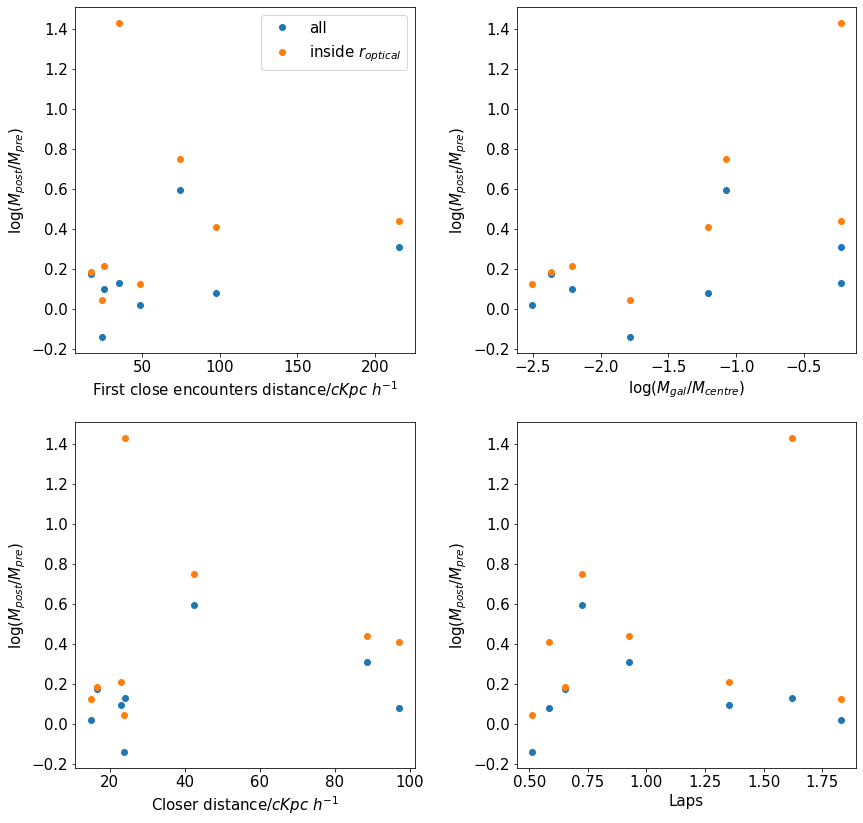

In [20]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.plot(periDist, np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(periDist, np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), np.log10(ratio), marker='o', ls=' ')
pl.plot(np.log10(MassRatio), np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 3)

pl.plot(minDist, np.log10(ratio), marker='o', ls=' ')
pl.plot(minDist, np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, np.log10(ratio), marker='o', ls=' ')
pl.plot(NLaps, np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('$\log(M_{post}/M_{pre})$')

array([0.12743315, 0.00856862, 0.18828203, 0.14882868, 0.03547629,
       0.23756762, 0.04542094, 0.2909007 ])

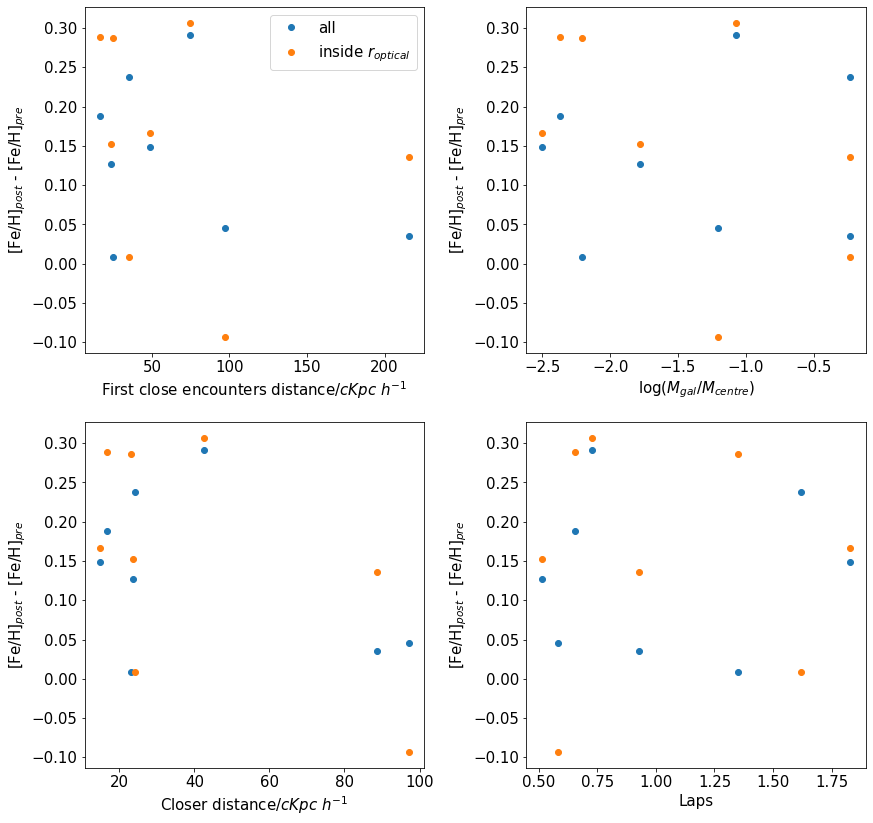

In [21]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.plot(periDist, difFeH, marker='o', ls=' ', label='all')
pl.plot(periDist, difFeH_optical, marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), difFeH, marker='o', ls=' ')
pl.plot(np.log10(MassRatio), difFeH_optical, marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(minDist, difFeH, marker='o', ls=' ')
pl.plot(minDist, difFeH_optical, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, difFeH, marker='o', ls=' ')
pl.plot(NLaps, difFeH_optical, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

difFeH

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

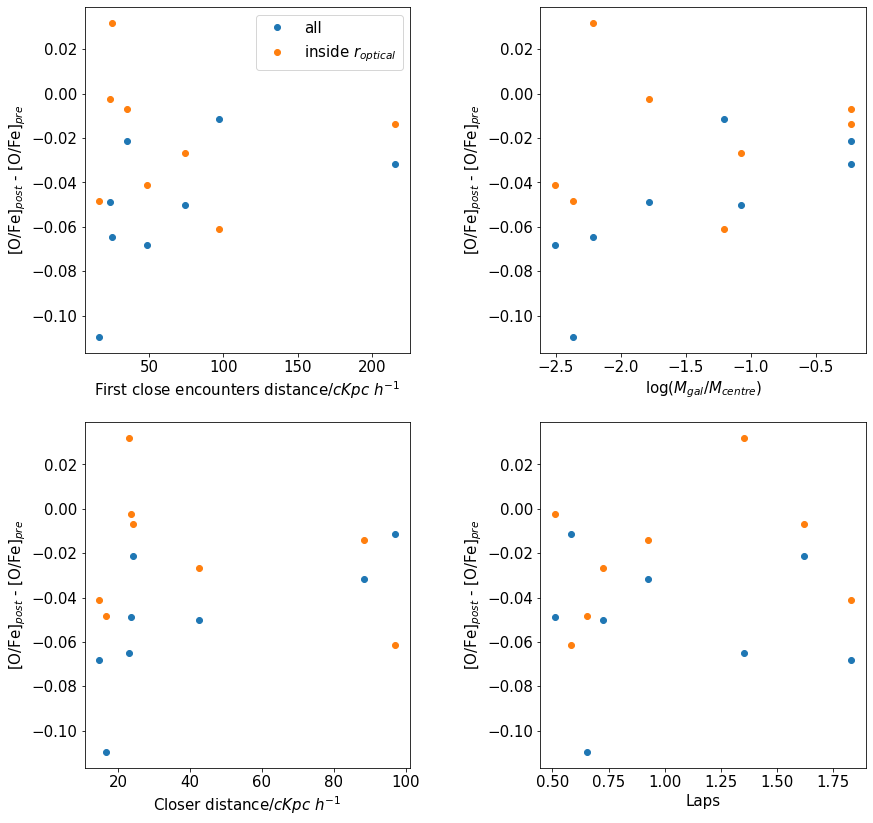

In [22]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(periDist, difOFe, marker='o', ls=' ', label='all')
pl.plot(periDist, difOFe_optical, marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), difOFe, marker='o', ls=' ')
pl.plot(np.log10(MassRatio), difOFe_optical, marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(minDist, difOFe, marker='o', ls=' ')
pl.plot(minDist, difOFe_optical, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, difOFe, marker='o', ls=' ')
pl.plot(NLaps, difOFe_optical, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

In [23]:
# ok, lets take a look at the metallicity as function of time for the particles pre and post.

In [24]:
def getAllLastP_ID(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, MassList, AbundList = [], [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]

                GMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                MassList.extend(list(GMass))
                AbundList.extend(list(GAbund))

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    MassList = np.array(MassList)
    AbundList = np.array(AbundList)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    MassList = MassList[Idunique]
    AbundList = AbundList[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    MassList_ = MassList[iidex_]
    AbundList_ = AbundList[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Massorder = np.zeros(IndexT_.size)
    Abundorder = np.zeros((IndexT_.size, 12))
    
    snaporder[is1] = snaplist_[is2]
    Massorder[is1] = MassList_[is2]
    Abundorder[is1] = AbundList_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Massorder, Abundorder, IndexT_near

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

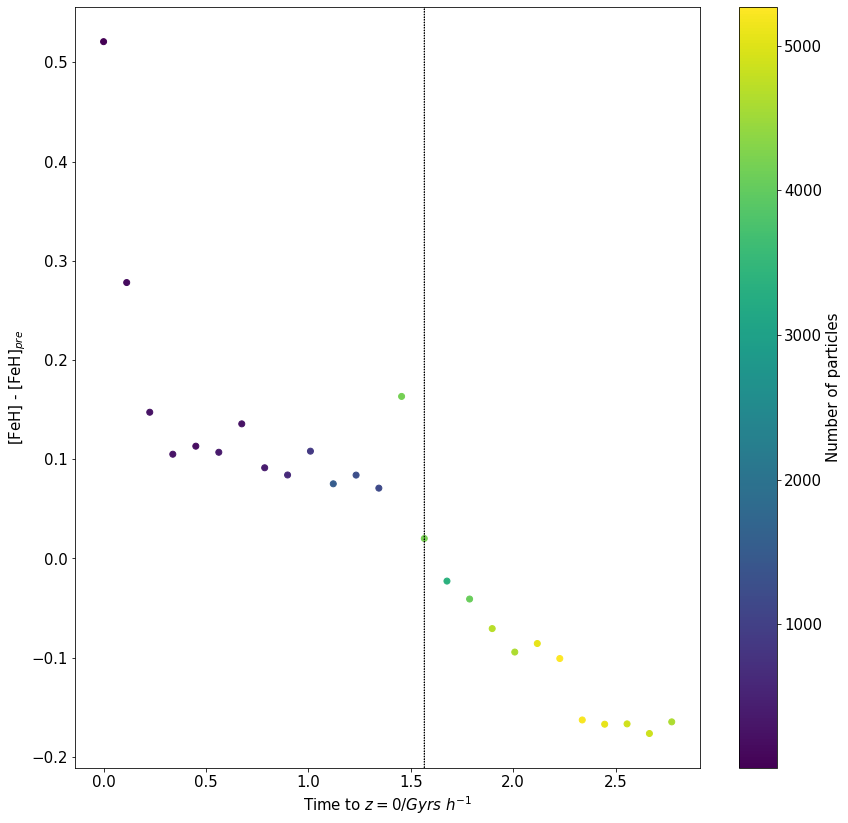

In [25]:
gal, cen = 4338, 4337

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

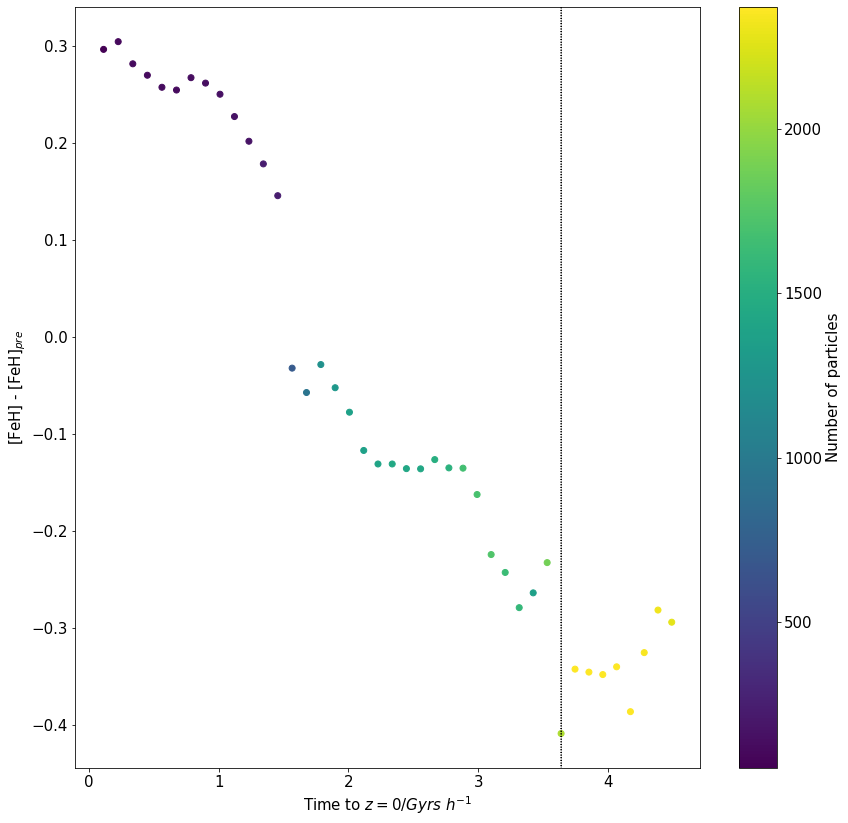

In [26]:
gal, cen = 4339, 4337

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

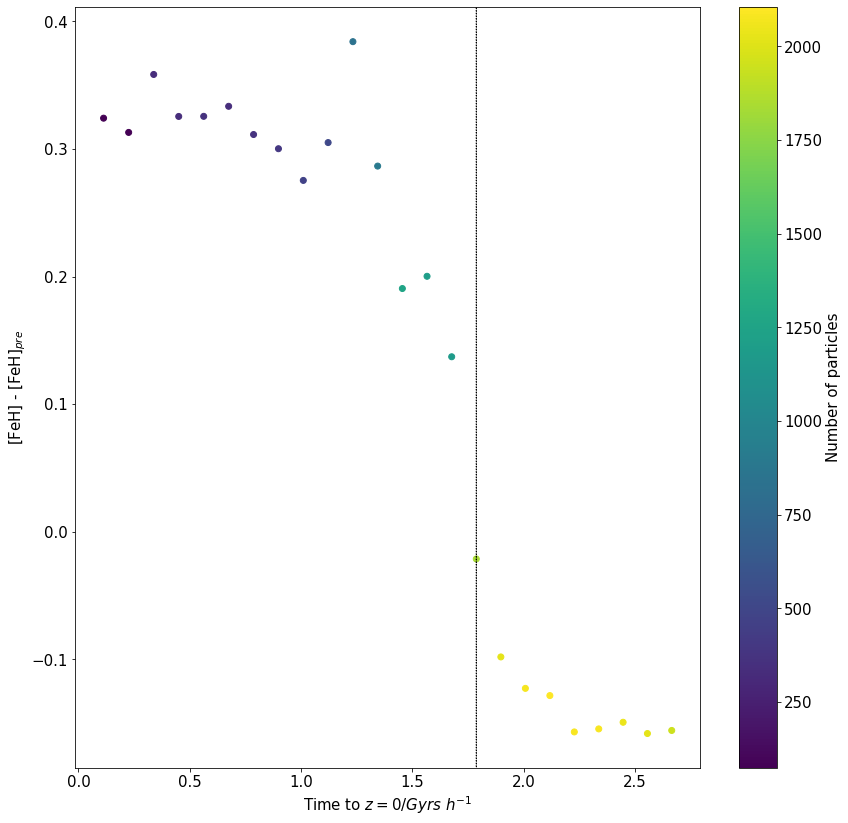

In [27]:
gal, cen = 4341, 4337

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

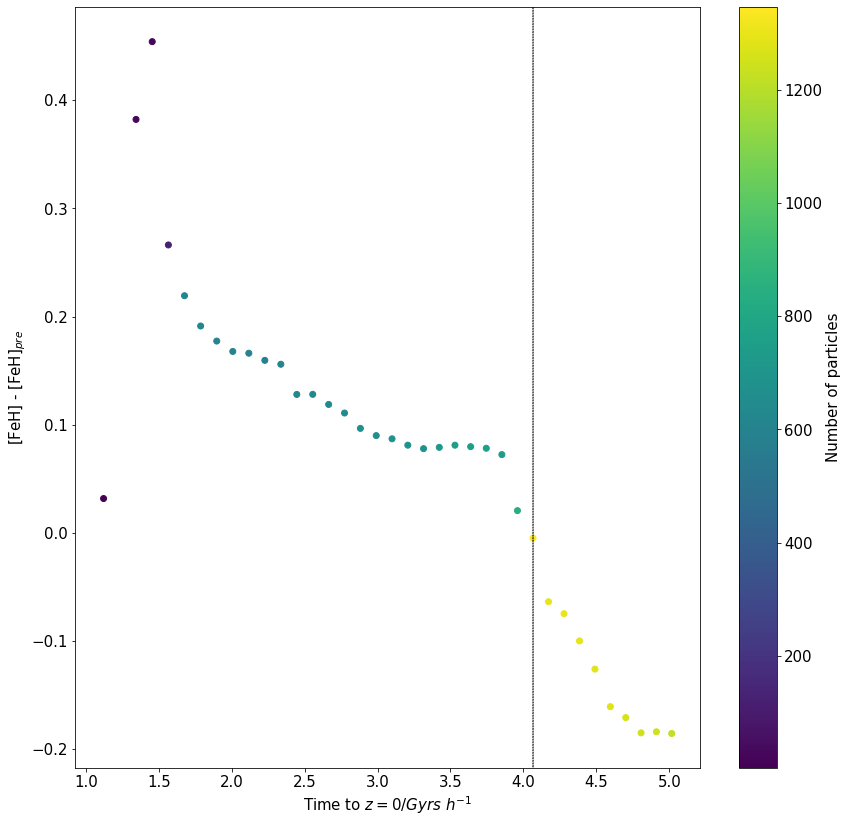

In [28]:
gal, cen = 4343, 4337

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

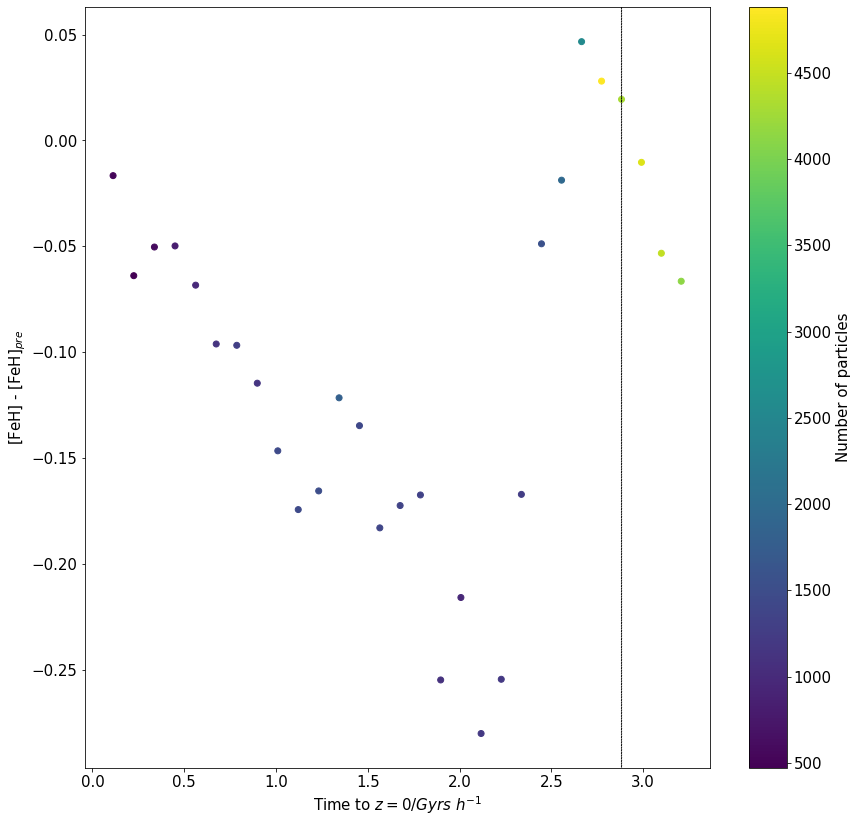

In [29]:
gal, cen = 4470, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

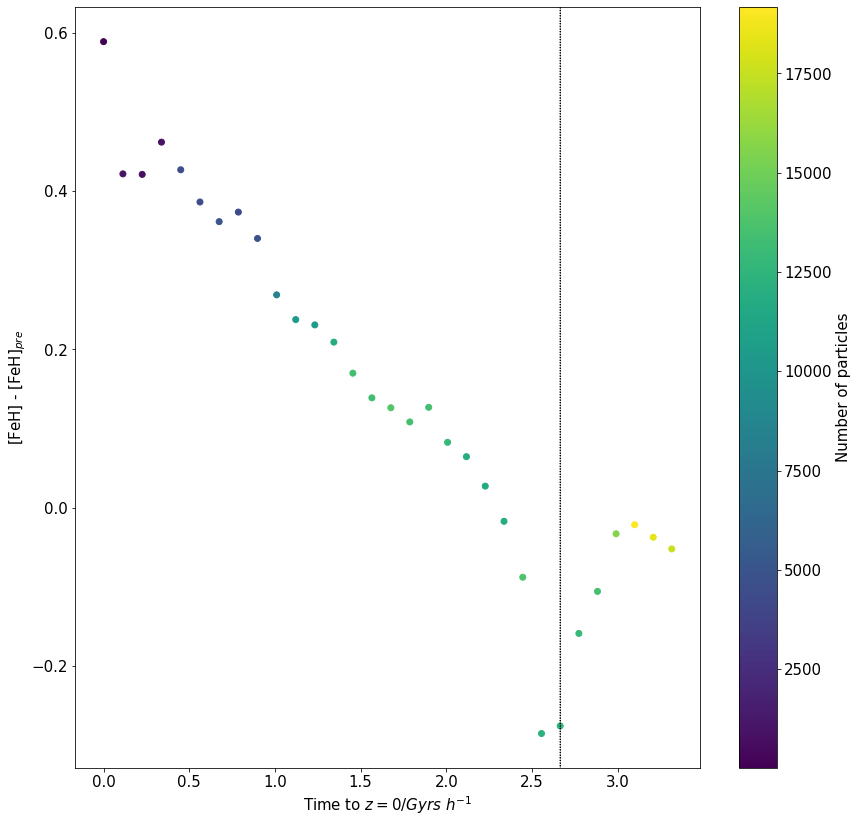

In [30]:
gal, cen = 4471, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

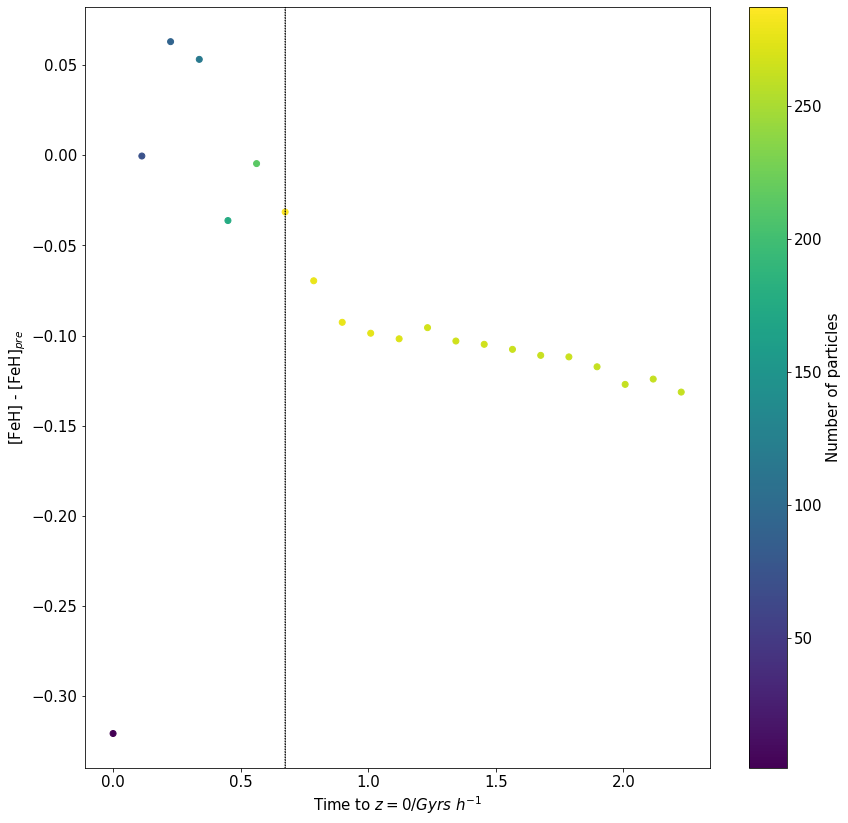

In [31]:
gal, cen = 4473, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '[FeH] - [FeH]$_{pre}$')

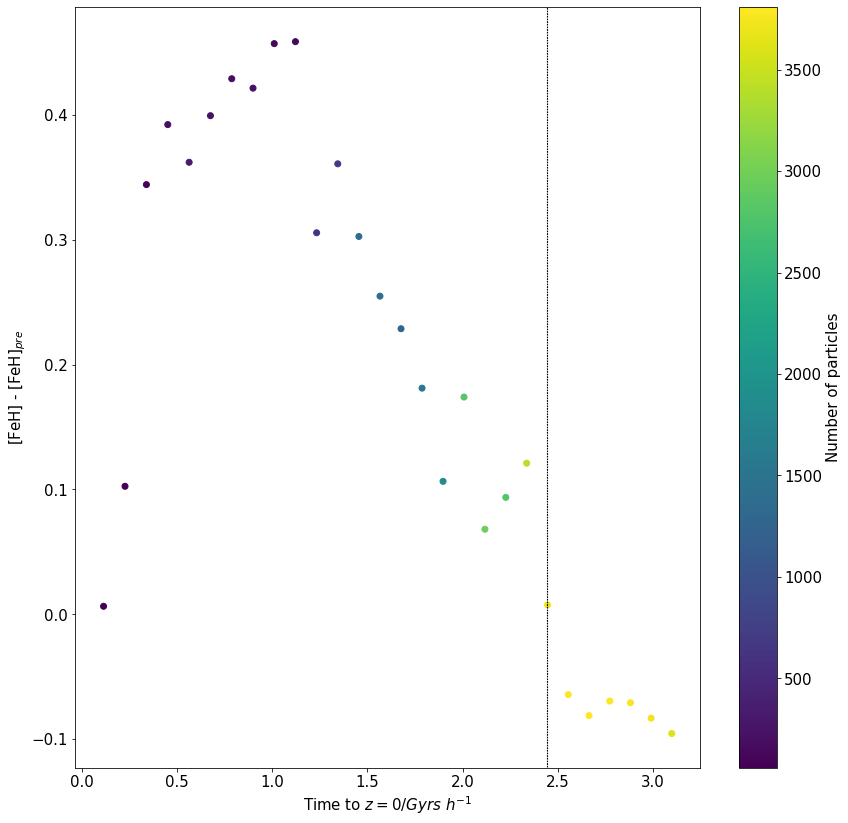

In [32]:
gal, cen = 4474, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder, IDs = getAllLastP_ID(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

AbundPre = Abundorder[ipre]
AbundPost = Abundorder[ipost]

IDsPost = IDs[ipost]

PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IDsPost]

FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
FeHPre = FeHPre[iFpre]
FeHPost = FeHPost[iFpost]

FeHBase = np.median(FeHPre)

snaplist = np.arange(128, firstsnap, -1)
zl = []

medFeH = []
numb = []

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

for mm in mtree:
    ss, idd = split_unique_id(int(mm))
    if ss>firstsnap:
        offGal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(ss)][idd].astype('int')
        IdsInGal =  sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][offGal[0]:offGal[1]]
    
#         IDssnap = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(ss)][()]
    
#         IdsP = np.isin(IDssnap, PIDs)
#         IdsP_ = np.where(IdsP)[0]
        
#         IDsRem = IDssnap[IdsP_]
        
#         areingal = np.isin(IDsRem, IdsInGal)
#         areingal_ = np.where(areingal)[0]
#         IdsP__ = IdsP_[areingal]
        ids = np.arange(offGal[0],offGal[1])
        are = np.isin(IdsInGal, PIDs)
        IdsP__ = ids[are]
    
        AbdsT = sim['SnapNumber_{}/PartType0/Abundances'.format(ss)][IdsP__]
        FeHT = np.log10((AbdsT[:,4]/FeMass)/(AbdsT[:,6]/HMass)) - NfeNhe_sun
        ift = np.where((np.isnan(FeHT)==False) & (np.isinf(FeHT)==False))
        FeHT = FeHT[ift]
    
        zn = sim['SnapNumber_{}/Header/Redshift'.format(ss)][()]
        med = np.median(FeHT) - FeHBase
        medFeH.append(med)
        zl.append(zn)
        numb.append(IdsP__.size)
    
zl = np.array(zl)
medFeH = np.array(medFeH)
numb = np.array(numb)

zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
timePeri = Cosmo.lookback_time(zPeri).value

time = Cosmo.lookback_time(zl).value


pl.figure(figsize=(14,14))

pl.scatter(time, medFeH, marker='o', c=numb)

pl.arrow(timePeri, -100, 0, 200, ls=':', color='black')

bar = pl.colorbar(label='Number of particles')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')
pl.ylabel('[FeH] - [FeH]$_{pre}$')

In [33]:
# ok, lets test tha tidal stripping at peri
Msun = 1.988*1e30 # msun in kg
kpc = 3.086*1e16 # kpc in m
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
DMmass = sim['SnapNumber_128/Header/MassTable'][1]

def tidal(idd, iddC, snap):
    
    OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
    OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]]
    GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
    DMMass = DMmass*np.ones(OFFDM[1]-OFFDM[0]) 

    MassList = list(StarMass)
    MassList.extend(list(GasMass))
    MassList.extend(list(DMMass))
    MassList = np.array(MassList)

    OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
    OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
    OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')

    CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    distB = np.sqrt(np.sum((CenG-CenP)**2.))

    StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]

    xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
    rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
    iSCN = np.where(rSC<distB)

    xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
    rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
    iGCN = np.where(rGC<distB)

    xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
    rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
    iDCN = np.where(rDC<distB)

    SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    StarMassC = np.sum(SMassC[iSCN])
    GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    GasMassC = np.sum(GMassC[iGCN])
    DMMassC = DMmass*(iDCN[0].size) 

    CenMass = StarMassC+GasMassC+DMMassC
    
    CenPos = CenP-CenG
    
    GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
    Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
    StarPos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStars[0]:OFFStars[1]]
    Sx, Sy, Sz = StarPos[:,0] - CenG[0], StarPos[:,1] - CenG[1], StarPos[:,2] - CenG[2]
    DMPos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDM[0]:OFFDM[1]]
    Dx, Dy, Dz = DMPos[:,0] - CenG[0], DMPos[:,1] - CenG[1], DMPos[:,2] - CenG[2]
    
    X, Y, Z = [], [], []
    X.extend(list(Sx)), Y.extend(list(Sy)), Z.extend(list(Sz))
    X.extend(list(Gx)), Y.extend(list(Gy)), Z.extend(list(Gz))
    X.extend(list(Dx)), Y.extend(list(Dy)), Z.extend(list(Dz))
    
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    
    # I think we got all, so far.
    Xt, Yt, Zt = [], [], []
    
    CenMassM = CenMass*1e10 # in M_sun
    
    for ms, xx, yy, zz in zip(MassList, X, Y, Z):
        msS = ms*1e10 # same
        dist = np.sqrt((xx-CenPos[0])**2+(yy-CenPos[1])**2+(zz-CenPos[2])**2)
        cross = np.cross(np.array([xx, yy, zz]), CenPos)
        tt = G*msS*CenMassM*cross/dist**3. # i dont know if this is gonna make sense, i guess is not to heavy
        
        Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])
        
    Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
    XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
    To = np.sqrt(XTT**2+YTT**2+ZTT**2.)
    
    # but this is in Km^s/s^2 M_sun, hey, thats not too bad
    ToNM = To*Msun*1e6 # now is in Nm
    
    return ToNM, To # return both, just in case

In [34]:
# ok, lets test this before the thing.

gal, cen = 4338, 4337

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)

uniqueID = int(127*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
uniqueIDC = int(127*1e6+center)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
satATS, cenATS = 0, 0
    
for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    if snap==Snap:
        satATS = idd
        cenATS = iddC
        break
        
toNM, to = tidal(gal, cen, 128)
toNMS, toS = tidal(satATS, cenATS, Snap)

to, toS

(221782719434.96777, 966543721.7809556)

In [35]:
TidalT, TidalTNM = [], []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)

    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    satATS, cenATS = 0, 0

    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        if snap==Snap:
            satATS = idd
            cenATS = iddC
            break

    toNMS, toS = tidal(satATS, cenATS, Snap)

    TidalT.append(toS)
    TidalTNM.append(toNMS)
    
    c += 1
    bar.update(c)
    
TidalT, TidalTNM = np.array(TidalT), np.array(TidalTNM)

100% (8 of 8) |##########################| Elapsed Time: 0:00:14 ETA:  00:00:00

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

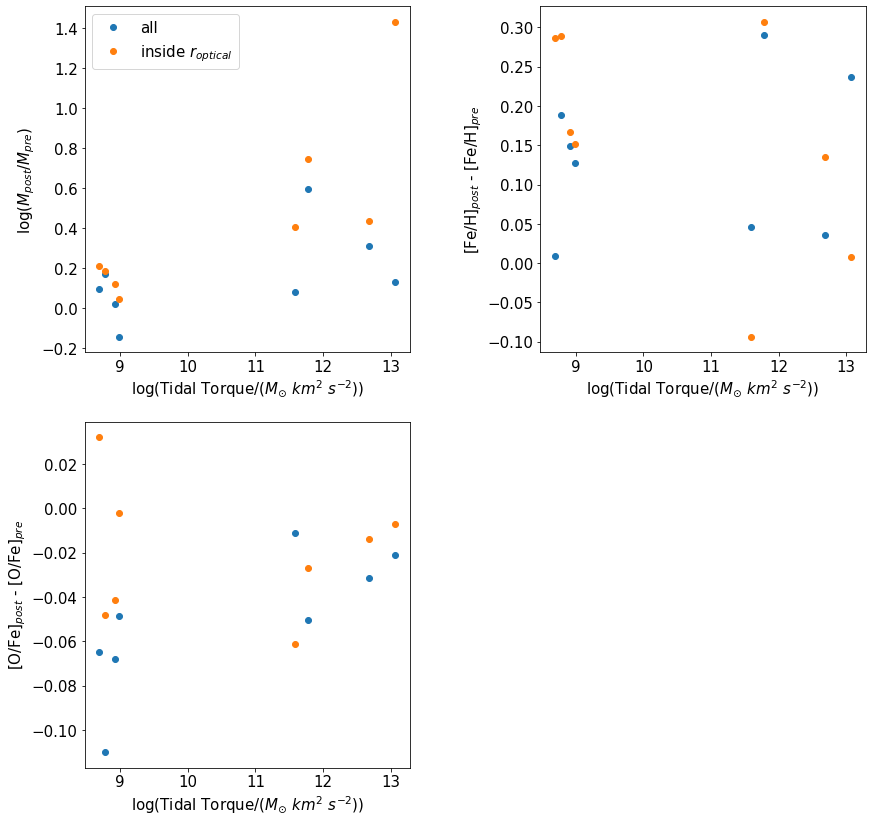

In [36]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(TidalT), np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(np.log10(TidalT), np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(TidalT), difFeH, marker='o', ls=' ')
pl.plot(np.log10(TidalT), difFeH_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(np.log10(TidalT), difOFe, marker='o', ls=' ')
pl.plot(np.log10(TidalT), difOFe_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')


In [37]:
# ok, lets see teh internal energy at teh moment of lost

# until this is equal to the last, lets see.

def getAllLastP_bind(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, BiE = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]
                bindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                BiE.extend(list(bindE))

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    BiE = np.array(BiE)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    BiE = BiE[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    BiE_ = BiE[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    BiEorder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    BiEorder[is1] = BiE_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, BiEorder


def getAllLastP_bind_optical(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, BiE = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

                rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

                posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

                xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

                rr = np.sqrt(xx**2+yy**2+zz**2)

                ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
                tempIds = tempIds[ik]

                BindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                BiE.extend(list(BindE))
            
    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    BiE = np.array(BiE)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    BiE = BiE[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    BiE_ = BiE[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    BiEorder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    BiEorder[is1] = BiE_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, BiEorder

In [38]:
# difBiE = []
# difBiE_optical = []

# bar = progressbar.ProgressBar(max_value=8)

# c = 0

# for gal, cen in zip(listOfGal, listOfCen):
#     physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
#     snaporder, BiE = getAllLastP_bind(gal, cen, firstsnap)
#     snaporder_opt, BiE_opt = getAllLastP_bind_optical(gal, cen, firstsnap)

#     ipre = np.where(snaporder<Snap)
#     ipost = np.where(snaporder>=Snap)
    
#     ipre_opt = np.where(snaporder_opt<Snap)
#     ipost_opt = np.where(snaporder_opt>=Snap)
    
#     BiEPre = np.median(BiE[ipre])
#     BiEPost = np.median(BiE[ipost])
    
#     difBiE.append(BiEPost/BiEPre)

#     BiEPre_opt = np.median(BiE_opt[ipre_opt])
#     BiEPost_opt = np.median(BiE_opt[ipost_opt])
    
#     difBiE_optical.append(BiEPost_opt/BiEPre_opt)
    
#     c += 1
#     bar.update(c)
    

# difBiE = np.array(difBiE)
# difBiE_optical = np.array(difBiE_optical)

In [39]:
# pl.figure(figsize=(14, 14))

# pl.subplots_adjust(wspace=0.4)

# pl.subplot(2, 2, 1)

# pl.plot(np.log10(TidalT), np.log10(ratio), marker='o', ls=' ', label='all')
# pl.plot(np.log10(TidalT), np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

# pl.legend(loc='best')

# pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
# pl.ylabel('$\log(M_{post}/M_{pre})$')

# pl.subplot(2, 2, 2)

# pl.plot(np.log10(TidalT), difFeH, marker='o', ls=' ')
# pl.plot(np.log10(TidalT), difFeH_optical, marker='o', ls=' ')

# pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
# pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

# pl.subplot(2, 2, 3)

# pl.plot(np.log10(TidalT), difOFe, marker='o', ls=' ')
# pl.plot(np.log10(TidalT), difOFe_optical, marker='o', ls=' ')

# pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
# pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

# pl.subplot(2, 2, 4)

# pl.plot(np.log10(TidalT), difBiE, marker='o', ls=' ')
# pl.plot(np.log10(TidalT), difBiE_optical, marker='o', ls=' ')

# pl.xlabel('log(Tidal Torque/$(M_{\odot}\,\,km^2\,\,s^{-2})$)')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')

In [40]:
def tidalA(gal, cen, snap):
    
    OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
    OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]]
    GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
    DMMass = DMmass*np.ones(OFFDM[1]-OFFDM[0]) 

    MassList = list(StarMass)
    MassList.extend(list(GasMass))
    MassList.extend(list(DMMass))
    MassList = np.array(MassList)

    OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
    OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
    OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')

    CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    distB = np.sqrt(np.sum((CenG-CenP)**2.))

    StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]

    xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
    rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
    iSCN = np.where(rSC<distB)

    xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
    rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
    iGCN = np.where(rGC<distB)

    xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
    rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
    iDCN = np.where(rDC<distB)

    SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    StarMassC = np.sum(SMassC[iSCN])
    GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    GasMassC = np.sum(GMassC[iGCN])
    DMMassC = DMmass*(iDCN[0].size) 

    CenMass = StarMassC+GasMassC+DMMassC
    
    CenPos = CenP-CenG
    
    GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
    Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
    StarPos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStars[0]:OFFStars[1]]
    Sx, Sy, Sz = StarPos[:,0] - CenG[0], StarPos[:,1] - CenG[1], StarPos[:,2] - CenG[2]
    DMPos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDM[0]:OFFDM[1]]
    Dx, Dy, Dz = DMPos[:,0] - CenG[0], DMPos[:,1] - CenG[1], DMPos[:,2] - CenG[2]
    
    X, Y, Z = [], [], []
    X.extend(list(Sx)), Y.extend(list(Sy)), Z.extend(list(Sz))
    X.extend(list(Gx)), Y.extend(list(Gy)), Z.extend(list(Gz))
    X.extend(list(Dx)), Y.extend(list(Dy)), Z.extend(list(Dz))
    
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    
    # I think we got all, so far.
    Xt, Yt, Zt = [], [], []
    
    CenMassM = CenMass*1e10 # in M_sun
    
    for ms, xx, yy, zz in zip(MassList, X, Y, Z):
        msS = ms*1e10 # same
        dist = np.sqrt((xx-CenPos[0])**2+(yy-CenPos[1])**2+(zz-CenPos[2])**2)
        cross = np.cross(np.array([xx, yy, zz]), CenPos)
        tt = G*CenMassM*cross/dist**3. # i dont know if this is gonna make sense, i guess is not to heavy
        
        Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])
        
    Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
    XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
    To = np.sqrt(XTT**2+YTT**2+ZTT**2.)
    
    return To # return both, just in case

In [41]:
TidalA = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)

    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    satATS, cenATS = 0, 0

    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        if snap==Snap:
            satATS = idd
            cenATS = iddC
            break

    to = tidalA(satATS, cenATS, Snap)

    TidalA.append(to)
    
    c += 1
    bar.update(c)
    
TidalA = np.array(TidalA)

100% (8 of 8) |##########################| Elapsed Time: 0:00:12 ETA:  00:00:00

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

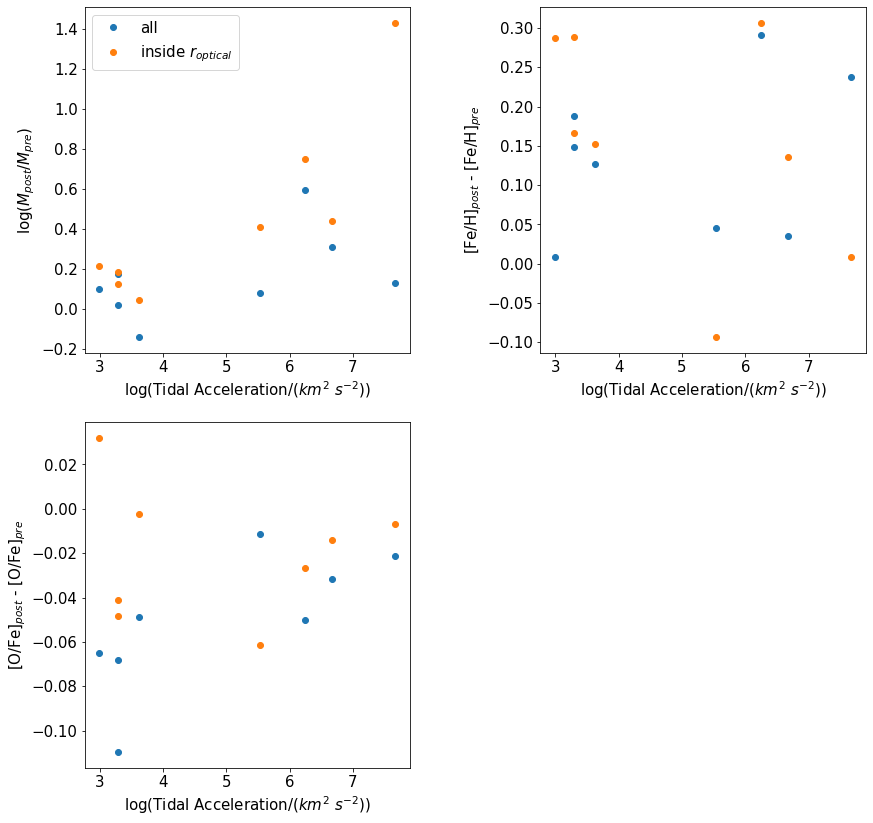

In [42]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(TidalA), np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(np.log10(TidalA), np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('log(Tidal Acceleration/$(km^2\,\,s^{-2})$)')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(TidalA), difFeH, marker='o', ls=' ')
pl.plot(np.log10(TidalA), difFeH_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Acceleration/$(km^2\,\,s^{-2})$)')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(np.log10(TidalA), difOFe, marker='o', ls=' ')
pl.plot(np.log10(TidalA), difOFe_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Acceleration/$(km^2\,\,s^{-2})$)')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

# pl.subplot(2, 2, 4)

# pl.plot(np.log10(TidalA), difBiE, marker='o', ls=' ')
# pl.plot(np.log10(TidalA), difBiE_optical, marker='o', ls=' ')

# pl.xlabel('log(Tidal Acceleration/$(km^2\,\,s^{-2})$)')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')

In [43]:
TidalA

array([4.22892404e+03, 9.90508267e+02, 1.95059552e+03, 1.97129949e+03,
       4.70285244e+06, 4.68794035e+07, 3.38764780e+05, 1.75941314e+06])

In [44]:
MassList = []

for gal, cen in zip(listOfGal, listOfCen):
    OFFGas = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    OFFDM = sim['SnapNumber_128/SubGroups/PartType1/Offsets'][gal].astype('int')
    OFFStars = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    StarMass = sim['SnapNumber_128/PartType4/Masses'][OFFStars[0]:OFFStars[1]]
    GasMass = sim['SnapNumber_128/PartType0/Masses'][OFFGas[0]:OFFGas[1]]
    DMMass = DMmass*np.ones(OFFDM[1]-OFFDM[0]) 
    
    tmass = np.sum(StarMass) + np.sum(GasMass) + np.sum(DMMass)
    MassList.append(tmass*1e10)
    
MassList = np.array(MassList)

In [45]:
MassList

array([4.09785219e+09, 1.92346463e+09, 1.69416528e+09, 3.23505307e+08,
       6.60344198e+10, 2.49445109e+10, 1.39809505e+10, 6.77309110e+09])

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

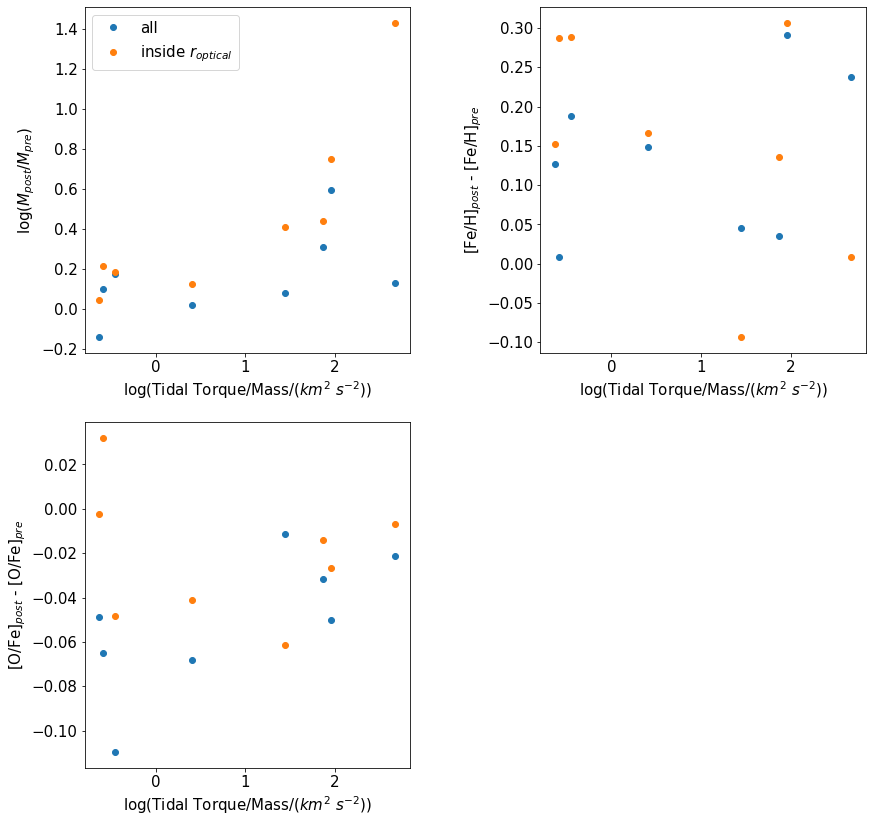

In [46]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(TidalT/MassList), np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(np.log10(TidalT/MassList), np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Mass/$(km^2\,\,s^{-2})$)')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(TidalT/MassList), difFeH, marker='o', ls=' ')
pl.plot(np.log10(TidalT/MassList), difFeH_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Torque/Mass/$(km^2\,\,s^{-2})$)')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(np.log10(TidalT/MassList), difOFe, marker='o', ls=' ')
pl.plot(np.log10(TidalT/MassList), difOFe_optical, marker='o', ls=' ')

pl.xlabel('log(Tidal Torque/Mass/$(km^2\,\,s^{-2})$)')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

# pl.subplot(2, 2, 4)

# pl.plot(np.log10(TidalT/MassList), difBiE, marker='o', ls=' ')
# pl.plot(np.log10(TidalT/MassList), difBiE_optical, marker='o', ls=' ')

# pl.xlabel('log(Tidal Torque/Mass/$(km^2\,\,s^{-2})$)')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')

In [47]:
Vel = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)

    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    satATS, cenATS = 0, 0

    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        if snap==Snap:
            satATS = idd
            cenATS = iddC
            break

    velgal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(Snap)][satATS]
    velcen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(Snap)][cenATS]

    vel = np.sqrt(np.sum((velgal-velcen)**2.))
    
    Vel.append(vel)
    
    c += 1
    bar.update(c)
    
Vel = np.array(Vel)

100% (8 of 8) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

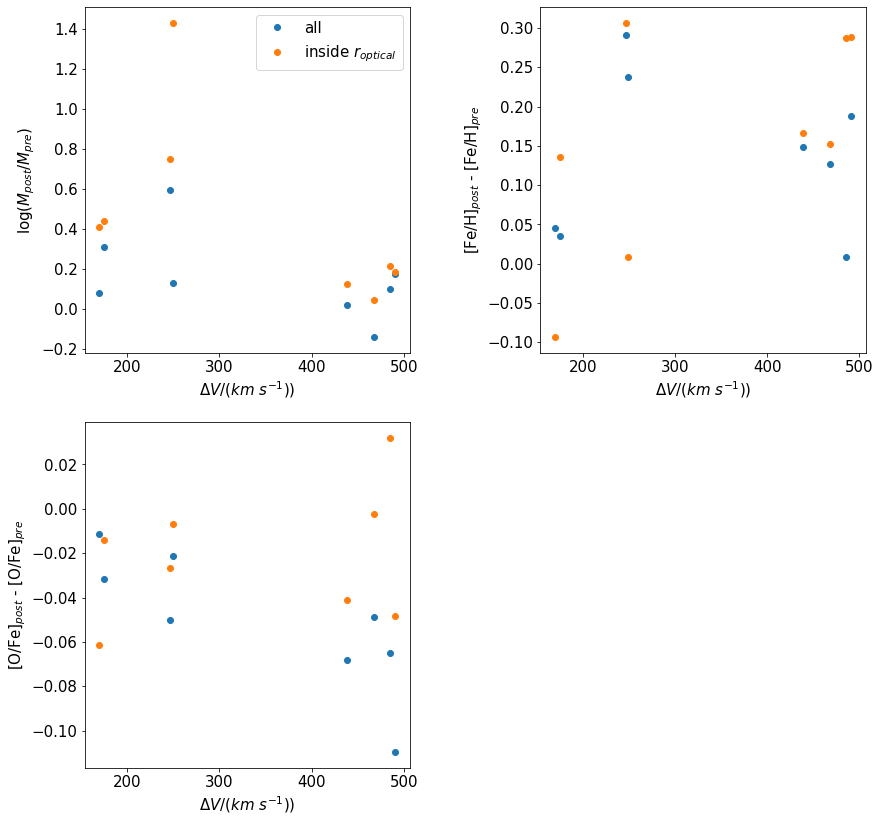

In [48]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(Vel, np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(Vel, np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('$\Delta V/(km\,\,s^{-1})$)')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(Vel, difFeH, marker='o', ls=' ')
pl.plot(Vel, difFeH_optical, marker='o', ls=' ')

pl.xlabel('$\Delta V/(km\,\,s^{-1})$)')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(Vel, difOFe, marker='o', ls=' ')
pl.plot(Vel, difOFe_optical, marker='o', ls=' ')

pl.xlabel('$\Delta V/(km\,\,s^{-1})$)')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

# pl.subplot(2, 2, 4)

# pl.plot(Vel, difBiE, marker='o', ls=' ')
# pl.plot(Vel, difBiE_optical, marker='o', ls=' ')

# pl.xlabel('$\Delta V/(km\,\,s^{-1})$)')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')

In [49]:
Vel

array([468.09686, 484.86447, 490.90598, 438.39578, 175.16884, 249.32587,
       170.08316, 246.59064], dtype=float32)

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

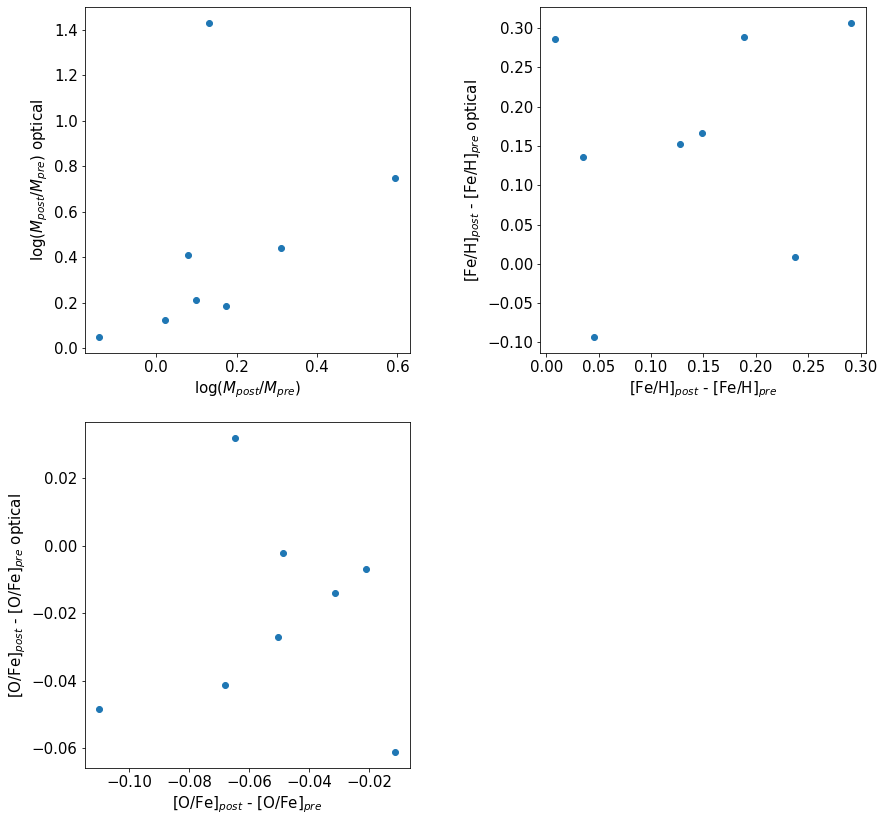

In [50]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(ratio), np.log10(ratio_optical), marker='o', ls=' ')

# pl.legend(loc='best')

pl.xlabel('$\log(M_{post}/M_{pre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$ optical')

pl.subplot(2, 2, 2)

pl.plot(difFeH, difFeH_optical, marker='o', ls=' ')

pl.xlabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$ optical')

pl.subplot(2, 2, 3)

pl.plot(difOFe, difOFe_optical, marker='o', ls=' ')

pl.xlabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

# pl.subplot(2, 2, 4)

# pl.plot(difBiE, difBiE_optical, marker='o', ls=' ')

# pl.xlabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$ optical')

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

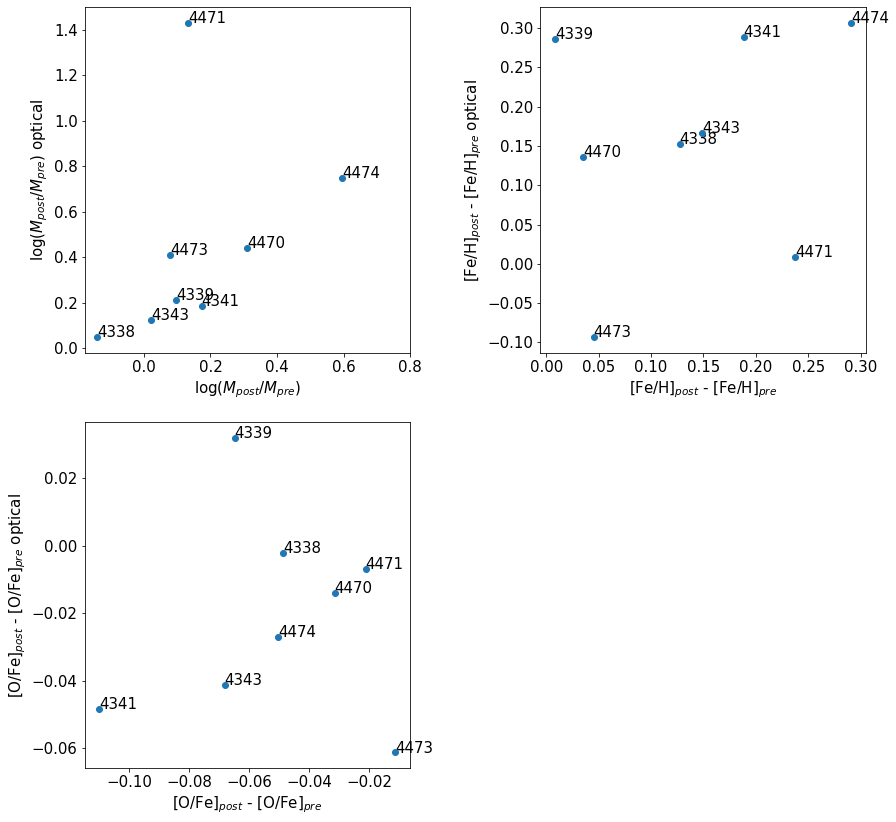

In [51]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(ratio), np.log10(ratio_optical), marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, np.log10(ratio), np.log10(ratio_optical)):
    pl.text(rx, ry, s, zorder=-10)

# pl.legend(loc='best')

pl.xlabel('$\log(M_{post}/M_{pre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$ optical')

xl = pl.xlim()  
pl.xlim(xl[0], 0.8)
pl.subplot(2, 2, 2)

pl.plot(difFeH, difFeH_optical, marker='o', ls=' ')


for s, rx, ry in zip(listOfGal, difFeH, difFeH_optical):
    pl.text(rx, ry, s, zorder=-10)

pl.xlabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$ optical')

pl.subplot(2, 2, 3)

pl.plot(difOFe, difOFe_optical, marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, difOFe, difOFe_optical):
    pl.text(rx, ry, s, zorder=-10)


pl.xlabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

# pl.subplot(2, 2, 4)

# pl.plot(difBiE, difBiE_optical, marker='o', ls=' ')

# for s, rx, ry in zip(listOfGal, difBiE, difBiE_optical):
#     pl.text(rx, ry, s, zorder=-10)

# pl.xlabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')
# pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$ optical')

In [52]:
# ok, lets see temperature, if help

def getAllLastP_temp(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, Temp = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]
#                 bindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
                IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
                ttemp = tempFromMass(Mass, Abund, IE, ne1)

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                Temp.extend(list(ttemp))

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    Temp = np.array(Temp)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    Temp = Temp[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    Temp_ = Temp[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Temporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    Temporder[is1] = Temp_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Temporder


def getAllLastP_temp_optical(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, Temp = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

                rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

                posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

                xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

                rr = np.sqrt(xx**2+yy**2+zz**2)

                ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
                tempIds = tempIds[ik]

#                 BindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#                 GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#                 tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]
#                 bindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
                IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
                ttemp = tempFromMass(Mass, Abund, IE, ne1)
                ttemp = ttemp[ik]
    
                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                Temp.extend(list(ttemp))
            
    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    Temp = np.array(Temp)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    Temp = Temp[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    Temp_ = Temp[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Temporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    Temporder[is1] = Temp_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Temporder

In [53]:
difTemp = []
difTemp_optical = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, Temp = getAllLastP_temp(gal, cen, firstsnap)
    snaporder_opt, Temp_opt = getAllLastP_temp_optical(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)
    
    ipre_opt = np.where(snaporder_opt<Snap)
    ipost_opt = np.where(snaporder_opt>=Snap)
    
    TempPre = np.median(Temp[ipre])
    TempPost = np.median(Temp[ipost])
    
    difTemp.append(TempPost/TempPre)

    TempPre_opt = np.median(Temp_opt[ipre_opt])
    TempPost_opt = np.median(Temp_opt[ipost_opt])
    
    difTemp_optical.append(TempPost_opt/TempPre_opt)
    
    c += 1
    bar.update(c)
    

difTemp = np.array(difTemp)
difTemp_optical = np.array(difTemp_optical)

100% (8 of 8) |##########################| Elapsed Time: 0:00:19 ETA:  00:00:00

Text(0, 0.5, 'log(Temperature$_{post}/$Temperature$_{pre}$ optical)')

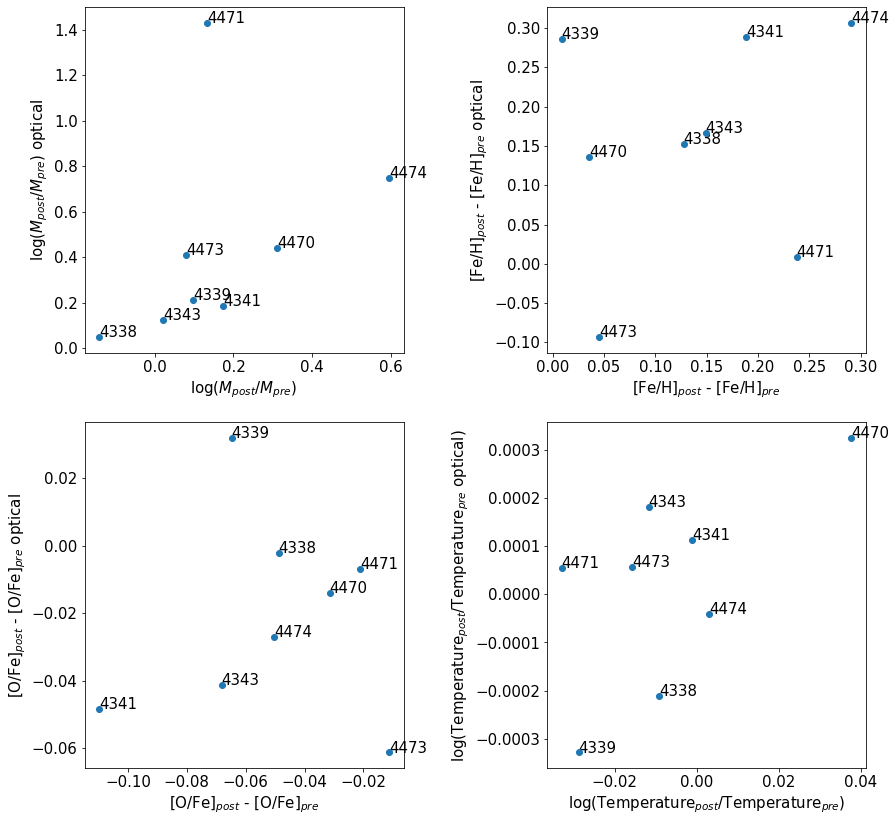

In [54]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.45)

pl.subplot(2, 2, 1)

pl.plot(np.log10(ratio), np.log10(ratio_optical), marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, np.log10(ratio), np.log10(ratio_optical)):
    pl.text(rx, ry, s, zorder=-10)

# pl.legend(loc='best')

pl.xlabel('$\log(M_{post}/M_{pre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$ optical')

pl.subplot(2, 2, 2)

pl.plot(difFeH, difFeH_optical, marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, difFeH, difFeH_optical):
    pl.text(rx, ry, s, zorder=-10)

pl.xlabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$ optical')

pl.subplot(2, 2, 3)

pl.plot(difOFe, difOFe_optical, marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, difOFe, difOFe_optical):
    pl.text(rx, ry, s, zorder=-10)

pl.xlabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

pl.subplot(2, 2, 4)

pl.plot(np.log10(difTemp), np.log10(difTemp_optical), marker='o', ls=' ')

for s, rx, ry in zip(listOfGal, difTemp, difTemp_optical):
    pl.text(np.log10(rx), np.log10(ry), s, zorder=-10)

pl.xlabel('log(Temperature$_{post}/$Temperature$_{pre}$)')
pl.ylabel('log(Temperature$_{post}/$Temperature$_{pre}$ optical)')

In [55]:
def compute_binding_energies(offsets, snap, sGroup):
    Potential = sim['SnapNumber_{}/PartType0/Potential'.format(snap)][offsets[0]:offsets[1]]
    Velocities = sim['SnapNumber_{}/PartType0/Velocities'.format(snap)][offsets[0]:offsets[1]]
    VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][sGroup]
    Coordinates = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offsets[0]:offsets[1]]
    CooCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][sGroup]
    box_size = sim['SnapNumber_{}/Header/BoxSize'.format(snap)][()]
    
    Time = sim['SnapNumber_{}/Header/Time'.format(snap)][()]
    HubbleParam = sim['SnapNumber_{}/Header/HubbleParam'.format(snap)][()]
    Omega0 = sim['SnapNumber_{}/Header/Omega0'.format(snap)][()]
    Redshift = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    cosmology = apc.FlatLambdaCDM(H0=HubbleParam * 100, Om0=Omega0)
    H = cosmology.H(Redshift).to('km kpc-1 s-1').value

    pVel = np.sqrt(Time) * Velocities
    
    rVelx, rVely, rVelz = pVel[:,0] - VelCen[0], pVel[:,1] - VelCen[1], pVel[:,2] - VelCen[2]
    rX, rY, rZ = Coordinates[:,0] - CooCen[0], Coordinates[:,1] - CooCen[1], Coordinates[:,2] - CooCen[2]
    hfX, hfY, hfZ = H*Time*rX, H*Time*rY, H*Time*rZ
    rR = np.sqrt(rX**2+rY**2+rZ**2)
    sortI = np.argsort(rR)
    iR = sortI[-1]
    outer_potential = Potential[iR]
    
    
    prVelx, prVely, prVelz = rVelx + hfX , rVely + hfY, rVelz + hfZ
    kinetic_energy = 0.5 * (prVelx**2 + prVely**2 + prVelz**2)
    
    binding_energies = (Potential - outer_potential) + kinetic_energy
    
    return binding_energies

def compute_binding_energies_OR(fname, snap_number):
    with h5py.File(fname, 'r') as simulation:
        snapshot = simulation[f'SnapNumber_{snap_number}']
        box_size = snapshot['Header/BoxSize'][()]
        HubbleParam = snapshot['Header/HubbleParam'][()]
        Omega0 = snapshot['Header/Omega0'][()]
        Time = snapshot['Header/Time'][()]
        Redshift = snapshot['Header/Redshift'][()]

    cosmology = apc.FlatLambdaCDM(H0=HubbleParam * 100, Om0=Omega0)

    spatial_datasets = [
        'Coordinates',
        'Velocities',
        'SubGroupPos',
        'SubGroupVel',
    ]

    datasets = ['ParticleIDs', 'Coordinates', 'Velocities', 'SubFindNumber', 'GroupNumber', 'Potential']

    with h5py.File(fname, 'r') as simulation:
        snapshot = simulation[f'SnapNumber_{snap_number}']

        df_tot = pd.DataFrame()
        for particle_type in [0, 4]:
            data = {}
            for dataset in datasets:
                if dataset in spatial_datasets:
                    for i, coor in enumerate(['x', 'y', 'z']):
                        data[dataset + f'_{coor}'] = snapshot[f'PartType{particle_type}/' + dataset][:, i]
                else:
                    data[dataset] = snapshot[f'PartType{particle_type}/' + dataset][:]
            df = pd.DataFrame(data)
            df['PartType'] = particle_type

            df_tot = pd.concat([df_tot, df], axis=0)

    datasets = ['SubGroupPos', 'SubGroupVel', 'SubFindNumber', 'GroupNumber']

    with h5py.File(fname, 'r') as simulation:
        snapshot = simulation[f'SnapNumber_{snap_number}']
        SubGroups = snapshot['SubGroups']
        data = {}
        for dataset in datasets:
            if dataset in spatial_datasets:
                for i, coor in enumerate(['x', 'y', 'z']):
                    data[dataset + f'_{coor}'] = SubGroups[dataset][:, i]
            else:
                data[dataset] = SubGroups[dataset][:]

    subgroups = pd.DataFrame(data)
    merged = df_tot.merge(subgroups, on=['SubFindNumber'])

    coors = ['x', 'y', 'z']
    Coordinates = merged[[f'Coordinates_{coor}' for coor in coors]].values
    SubGroupPos = merged[[f'SubGroupPos_{coor}' for coor in coors]].values

    merged['r'] = np.linalg.norm(Coordinates - SubGroupPos, axis=1)
    merged = merged.sort_values(['SubFindNumber', 'r'])

    groupby = merged.groupby('SubFindNumber')
    outer_potential = groupby.tail(1)[['SubFindNumber', 'Potential']]
    outer_potential = outer_potential.rename(columns={'Potential': 'outer_potential'})
    merged = merged.merge(outer_potential, on=['SubFindNumber'])

    Coordinates = merged[[f'Coordinates_{coor}' for coor in coors]].values
    SubGroupPos = merged[[f'SubGroupPos_{coor}' for coor in coors]].values

    peculiar_velocities = np.sqrt(Time) * merged[[f'Velocities_{coor}' for coor in coors]].values
    relative_velocities = peculiar_velocities - merged[[f'SubGroupVel_{coor}' for coor in coors]].values
    H = cosmology.H(Redshift).to('km kpc-1 s-1').value
    hubble_flow = H * Time * (Coordinates - SubGroupPos)
    relative_physical_velocities = relative_velocities + hubble_flow
    kinetic_energy = 0.5 * (relative_physical_velocities ** 2).sum(axis=1)

    binding_energies = (merged.Potential - merged.outer_potential) + kinetic_energy
    merged['BindingEnergy'] = binding_energies

    return merged


def getBind(offsets, snap, sGroup):
    fname = '/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5'
    allData = compute_binding_energies_OR(fname, snap)
    bindE = allData['BindingEnergy'].values
    ptype = allData['PartType'].values
    sfind = allData['SubFindNumber'].values

    ik = np.where((ptype==0) & (sfind==sGroup))[0]
    bindE = bindE[ik]
    
    # and get some order
    PIDs1 = sim['SnapNumber_128/PartType0/ParticleIDs'][OffGal[0]:OffGal[1]]
    PIDs2 = allData['ParticleIDs'][ik]
    
    BiEorder = np.zeros(PIDs1.size)
    is1 = np.argsort(PIDs1) # the target
    is2 = np.argsort(PIDs2)
    BiEorder[is1] = bindE[is2]
    
    return BiEorder

7425

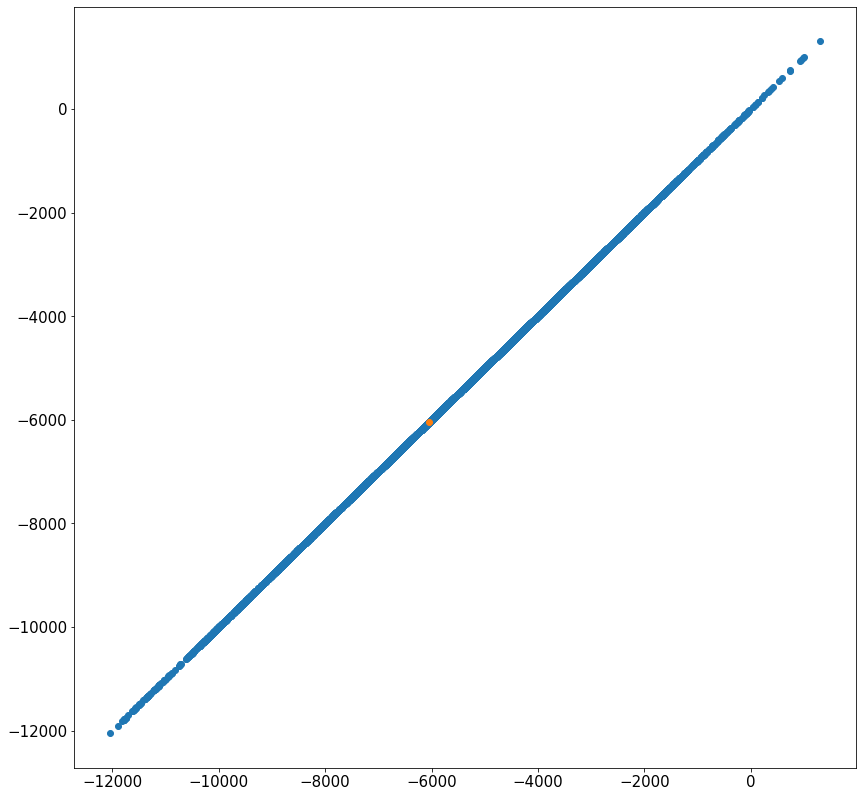

In [56]:
gal = 4474
OffGal = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')

Bie1 = sim['SnapNumber_128/PartType0/BindingEnergy'][OffGal[0]:OffGal[1]]
Bie2 = compute_binding_energies(OffGal, 128, gal)
Bie3 = getBind(OffGal, 128, gal)

# pl.figure(figsize=(14,14))
# a = pl.hist(Bie1-Bie2, histtype='step', bins=1000)

ii = np.where(np.abs(Bie1-Bie2)>1000)[0]
Potential = sim['SnapNumber_128/PartType0/Potential'][OffGal[0]:OffGal[1]]
Velocities =  sim['SnapNumber_128/PartType0/Velocities'][OffGal[0]:OffGal[1]]
Coordinates = sim['SnapNumber_128/PartType0/Coordinates'][OffGal[0]:OffGal[1]]

pl.figure(figsize=(14, 14))

pl.plot(Bie2, Bie3, ls=' ', marker='o')
pl.plot(Bie2[ii], Bie3[ii], ls=' ', marker='o')
Bie1.size

# pl.figure(figsize=(14,14))

# pl.subplot(2, 2, 1)

# pl.plot(Potential, Velocities[:,0], ls='', marker='o')
# pl.plot(Potential[ii], Velocities[ii,0], ls='', marker='o')

# pl.subplot(2, 2, 2)

# pl.plot(Velocities[:,1], Velocities[:,2], ls='', marker='o')
# pl.plot(Velocities[ii,1], Velocities[ii,2], ls='', marker='o')

# pl.subplot(2, 2, 3)

# pl.plot(Coordinates[:,0], Coordinates[:,1], ls='', marker='o')
# pl.plot(Coordinates[ii,0], Coordinates[ii,1], ls='', marker='o')

# pl.subplot(2, 2, 4)

# pl.plot(Coordinates[:,0], Coordinates[:,2], ls='', marker='o')
# pl.plot(Coordinates[ii,0], Coordinates[ii,2], ls='', marker='o')

In [57]:
# lets test this, everyone.
# ok, lets see the internal energy at the moment of lost

# until this is equal to the last, lets see.

def getAllLastP_bind(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, BiE = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]
#                 bindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                bindE = compute_binding_energies(tempOff, snap, idd)
                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                BiE.extend(list(bindE))

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    BiE = np.array(BiE)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    BiE = BiE[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    BiE_ = BiE[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    BiEorder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    BiEorder[is1] = BiE_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, BiEorder


def getAllLastP_bind_optical(fofID, centralID, snapmax):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, BiE = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

                rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

                posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

                xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

                rr = np.sqrt(xx**2+yy**2+zz**2)

                ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
                tempIds = tempIds[ik]

                #BindE = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
                BindE = compute_binding_energies(tempOff, snap, idd)
                GAbund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                BiE.extend(list(BindE[ik]))
            
    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    BiE = np.array(BiE)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    BiE = BiE[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    BiE_ = BiE[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    BiEorder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snaplist_[is2]
    BiEorder[is1] = BiE_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, BiEorder

In [58]:
difBiE = []
difBiE_optical = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, BiE = getAllLastP_bind(gal, cen, firstsnap)
    snaporder_opt, BiE_opt = getAllLastP_bind_optical(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)
    
    ipre_opt = np.where(snaporder_opt<Snap)
    ipost_opt = np.where(snaporder_opt>=Snap)
    
    BiEPre = np.median(BiE[ipre])
    BiEPost = np.median(BiE[ipost])
    
    difBiE.append(BiEPost/BiEPre)

    BiEPre_opt = np.median(BiE_opt[ipre_opt])
    BiEPost_opt = np.median(BiE_opt[ipost_opt])
    
    difBiE_optical.append(BiEPost_opt/BiEPre_opt)
    
    c += 1
    bar.update(c)
    

difBiE = np.array(difBiE)
difBiE_optical = np.array(difBiE_optical)

100% (8 of 8) |##########################| Elapsed Time: 0:00:21 ETA:  00:00:00

(-1.8006472777477924, 9.0)

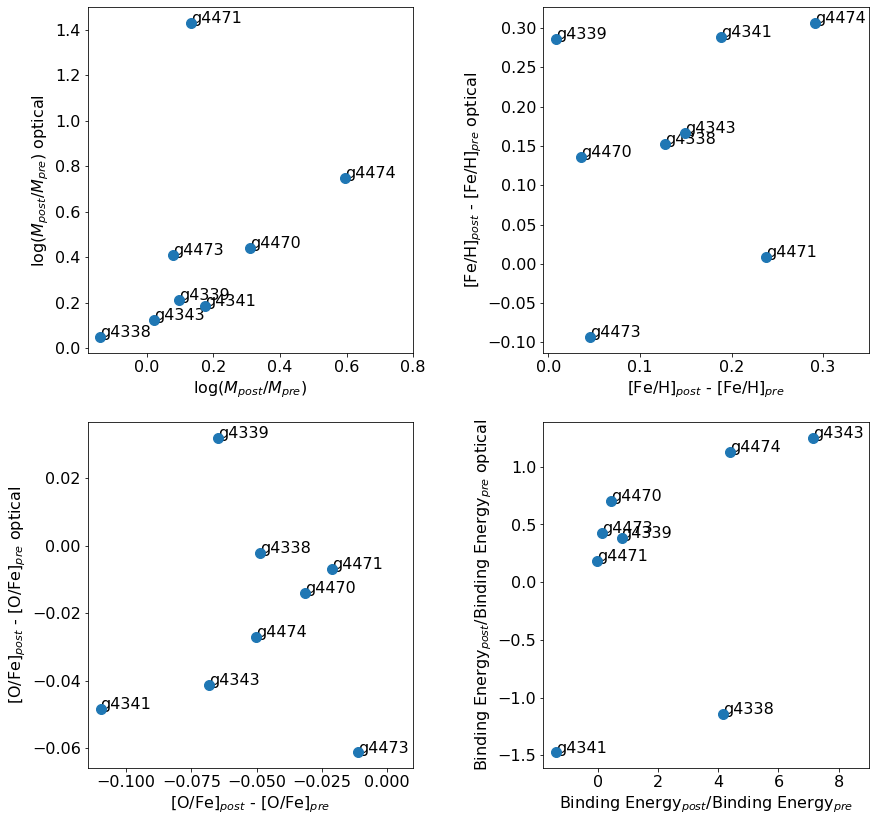

In [69]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(np.log10(ratio), np.log10(ratio_optical), marker='o', ls=' ', markersize=10)

for s, rx, ry in zip(listOfGal, np.log10(ratio), np.log10(ratio_optical)):
    pl.text(rx, ry, 'g{}'.format(s), zorder=-10)

# pl.legend(loc='best')

pl.xlabel('$\log(M_{post}/M_{pre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$ optical')

xl = pl.xlim()
pl.xlim(xl[0], 0.8)

pl.subplot(2, 2, 2)

pl.plot(difFeH, difFeH_optical, marker='o', ls=' ', markersize=10)


xl = pl.xlim()
pl.xlim(xl[0], 0.8)

for s, rx, ry in zip(listOfGal, difFeH, difFeH_optical):
    pl.text(rx, ry, 'g{}'.format(s), zorder=-10)

pl.xlabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$ optical')

xl = pl.xlim()
pl.xlim(xl[0], 0.35)

pl.subplot(2, 2, 3)

pl.plot(difOFe, difOFe_optical, marker='o', ls=' ', markersize=10)

for s, rx, ry in zip(listOfGal, difOFe, difOFe_optical):
    pl.text(rx, ry, 'g{}'.format(s), zorder=-10)


pl.xlabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$ optical')

xl = pl.xlim()
pl.xlim(xl[0], 0.01)

pl.subplot(2, 2, 4)

pl.plot(difBiE, difBiE_optical, marker='o', ls=' ', markersize=10)

for s, rx, ry in zip(listOfGal, difBiE, difBiE_optical):
    pl.text(rx, ry, 'g{}'.format(s), zorder=-10)

pl.xlabel('Binding Energy$_{post}/$Binding Energy$_{pre}$')
pl.ylabel('Binding Energy$_{post}/$Binding Energy$_{pre}$ optical')

xl = pl.xlim()
pl.xlim(xl[0], 9)

In [60]:
OffGal = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][4338].astype('int')

Bie1 = sim['SnapNumber_128/PartType0/BindingEnergy'][OffGal[0]:OffGal[1]]
Bie2 = compute_binding_energies(OffGal, 128, 4338)

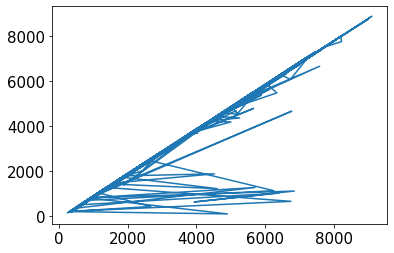

In [61]:
pl.plot(Bie1, Bie2)